This code is strictly for reference.

# Implementation of Variational Auto Encoder (VAE)

From: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from torchvision.utils import save_image, make_grid

In [11]:
# Model Hyperparameters

dataset_path = 'datasets'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

### 1. Loading (or downloading) MNIST

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 279kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.21MB/s]


### 2. Define the model

In [5]:
class Encoder(nn.Module):
    """Gaussian MLP Encoder."""
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    """Gaussian MLP Decoder."""
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [8]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):
        # Sample from standard normal
        epsilon = torch.randn_like(var).to(DEVICE)
        # Reparametrization trick
        z = mean + var * epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        # Takes exponential function (log_var -> var)
        z = self.reparametrization(mean, torch.exp(.5 * log_var))
        x_hat = self.decoder(z)

        return x_hat, mean, log_var

In [12]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(encoder=encoder, decoder=decoder).to(DEVICE)

### 3. Define Loss Function

In [13]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()


def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### 4. Train the Model

In [14]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _), in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"\tEpoch {epoch + 1} complete.\tAverage Loss: {overall_loss / (batch_idx * batch_size)}")
print("Finish.")

/home/polar0n/pyprojects/VAEs/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 1 complete.	Average Loss: 174.51568056135224
	Epoch 2 complete.	Average Loss: 127.89815556852567
	Epoch 3 complete.	Average Loss: 116.94554195142946
	Epoch 4 complete.	Average Loss: 112.8637272570169
	Epoch 5 complete.	Average Loss: 109.9727079311874
	Epoch 6 complete.	Average Loss: 108.29664398346202
	Epoch 7 complete.	Average Loss: 107.08574091584933
	Epoch 8 complete.	Average Loss: 106.15012773567926
	Epoch 9 complete.	Average Loss: 105.44986668862165
	Epoch 10 complete.	Average Loss: 104.95573470432491
	Epoch 11 complete.	Average Loss: 104.32961180417884
	Epoch 12 complete.	Average Loss: 103.93092991900564
	Epoch 13 complete.	Average Loss: 103.48447872104549
	Epoch 14 complete.	Average Loss: 103.08728815604132
	Epoch 15 complete.	Average Loss: 102.76971237870409
	Epoch 16 complete.	Average Loss: 102.457492141851
	Epoch 17 complete.	Average Loss: 102.13366616887521
	Epoch 18 complete.	Average Loss: 101.96569128886686
	Epoch 19 complete.	Average Loss: 101.80306498787041
	Epoch

### 5. Generate images from the model

In [17]:
import matplotlib.pyplot as plt
import tqdm

In [21]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm.tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)

        break


/home/polar0n/pyprojects/VAEs/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/100 [00:00<?, ?it/s]


In [22]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

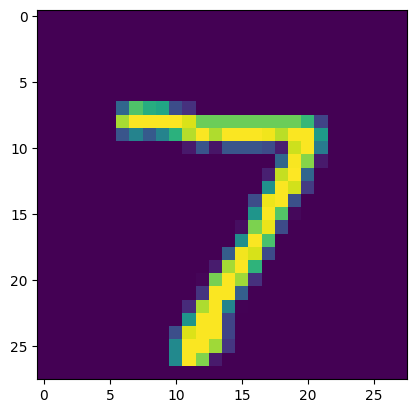

In [23]:
show_image(x, idx=0)

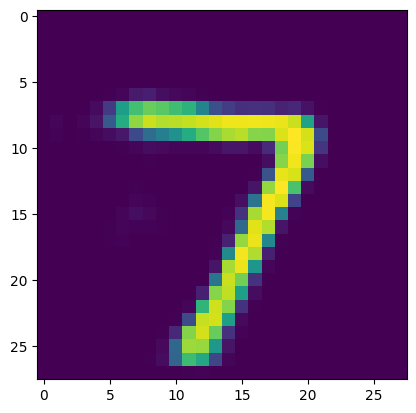

In [24]:
show_image(x_hat, idx=0)

### 6. Generate image from noise vector

__Please note that this is not the correct generative process.__

* Even if we don't know the exact $p(z\mid x)$, we can generate images from noise, since the loss function of training VAE regulates the $q(z\mid x)$ (simple and tractable posteriors) must close enough to $\mathcal{N}(0, I)$. If $q(z\mid x)$ is to $\mathcal{N}(0, I)$ "enough" (but not tightly close due to posterior collapse problem), $\mathcal{N}(0, I)$ may replace the encoder of VAE.

* To show this, a noise vector was sampled for testing similar to Generative Adversarial Networks.

In [25]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [26]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

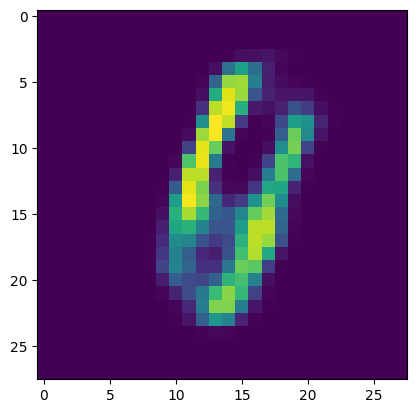

In [27]:
show_image(generated_images, idx=12)

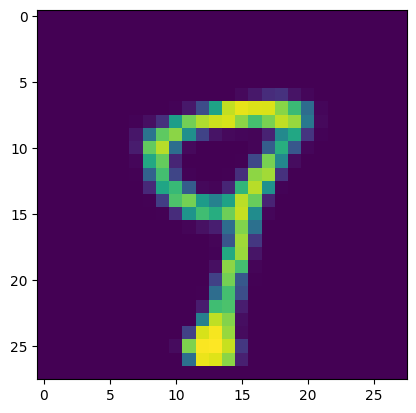

In [29]:
show_image(generated_images, idx=0)

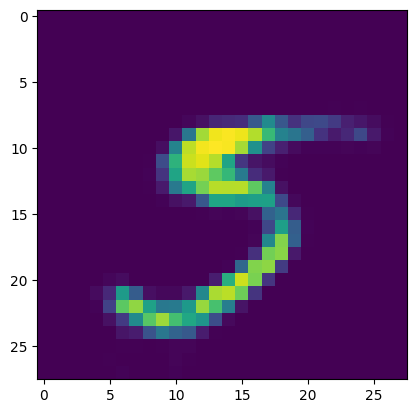

In [30]:
show_image(generated_images, idx=1)

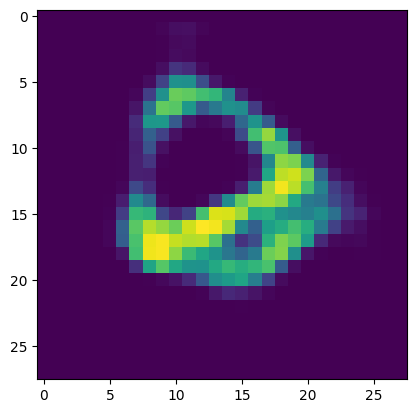

In [32]:
show_image(generated_images, idx=51)